In [279]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections.abc import Sequence
import time

np.set_printoptions(threshold=np.inf)

In [145]:
file = "/Users/ethanchan/Desktop/AIMAS/hw1-ekg/EKG/EKG_001-120/1.jpg"

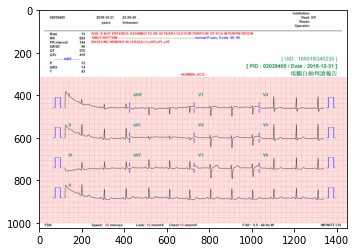

(1024, 1448, 3)

In [146]:
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image.shape # (height, width, channels)

### Problem 1: Divide the image into 12 leads

In [161]:
LEADS_PER_ROW = 4
LEADS_PER_COL = 3
X_INIT = 121
Y_INIT = 367
COL_WIDTH = 304
ROW_HEIGHT = 146

In [162]:
def get_subgraph_borders(row: int, col: int):
    return (X_INIT + COL_WIDTH * col,
            X_INIT + COL_WIDTH * (col + 1),
            Y_INIT + ROW_HEIGHT * row,
            Y_INIT + ROW_HEIGHT * (row + 1))

In [163]:
leads_1_to_12 = []

for col in range(LEADS_PER_ROW):
    for row in range(LEADS_PER_COL):
        left, right, top, bottom = get_subgraph_borders(row, col)
        subgraph = image[top: bottom, left: right, :]
        leads_1_to_12.append(subgraph)

        # plt.imshow(subgraph)
        # plt.show()

parsed_image = np.array(leads_1_to_12)
parsed_image.shape

(12, 146, 304, 3)

### Problem 2: Calculate the heart rate (bpm) using Limb Lead II

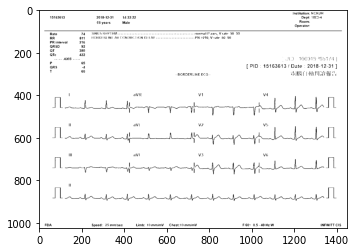

(1024, 1448)

In [252]:
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
threshold = 127
_, ret = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

plt.imshow(ret, cmap='gray', vmin=0, vmax=255)
plt.show()
image.shape

In [299]:
file = "/Users/ethanchan/Desktop/AIMAS/hw1-ekg/EKG/EKG_001-120/2.jpg"

In [253]:
def extract_LLII_subgraph(image: np.ndarray):
    return  image[Y_INIT + ROW_HEIGHT * 3: Y_INIT + ROW_HEIGHT * 4,
                  X_INIT: X_INIT + COL_WIDTH * 4]

In [305]:
def make_thresholded_LLII_graph(file: str):
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    # mask the green Roman numeral
    label_mask = np.zeros((17, 11), dtype=np.uint8)
    label_mask.fill(255)
    image[813:830, 139:150] = label_mask  

    image = extract_LLII_subgraph(image)

    threshold = 127
    _, image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    return image

# plt.figure(figsize=(15, 1), dpi=80)
# plt.imshow(image, cmap='gray', vmin=0, vmax=255)
# plt.show()
# image.shape # (height, width, channels)

In [306]:
def convert_2D_to_1D(image: np.ndarray):
    series = []
    BLACK = 0

    # draw signal
    for i in range(image.shape[1]):  # for each pixel on the x axis
        black_pixels_in_col = np.nonzero(image[:, i] == BLACK)[0]
        if black_pixels_in_col.size:
            series.append(int(np.median(black_pixels_in_col)))
        else:
            series.append(None)

    # fill in missing values
    for i, val in enumerate(series):
        if not val:  # no pixel, line segment is broken
            series[i] = next(item for item in series if item is not None)

    series = [100 - x for x in series]  # flip graph

    return np.array(series)

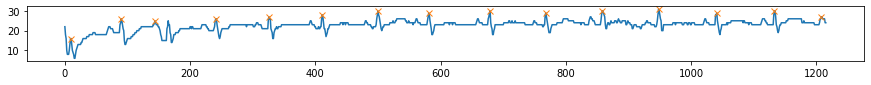

In [303]:
def calculate_heart_rate(series: np.ndarray):
    peaks, _ = find_peaks(series, distance=50)
    np.diff(peaks)
    plt.figure(figsize=(15, 1))
    plt.plot(series)
    plt.plot(peaks, series[peaks], "x")

In [ ]:
for i in range(1, 21):
    file = f"/Users/ethanchan/Desktop/AIMAS/hw1-ekg/EKG/EKG_001-120/{i}.jpg"
    image = make_thresholded_LLII_graph(file)
    series = convert_2D_to_1D(image)
    calculate_heart_rate(series)